In [1]:
%load_ext autoreload
%autoreload 2

# Assessing Multicollinearity

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, prepare_data, get_pi_matrix, get_condition_number

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from collections import Counter
from scipy.stats import f
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

plt.rc('font',family = 'serif')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
features = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
features_latex = ["$I_p$","$B_t$","$\\bar{n}_e$","$P_{l,th}$","$R_{geo}$","$\\kappa_a$","$\\epsilon$","$M_{eff}$"]

In [4]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = 1

DB5.insert(loc=2,column="label_9998",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = 1

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


# See functions inside `tokamakTK`

```Python
columns=['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF'],
```

In [5]:
all_cases = [prepare_data(DB2.copy(), features,True),  #0 DB2
             prepare_data(DB5.copy(), features,True),  #1 DB5
             prepare_data(DB5[DB5.label_6357.isin([1]) | DB5.id.isin(DB2.id.values)], features,True),  #2 Decreasing DB5 ~ 0.64
             prepare_data(DB5[DB5.label_6357.isin([0])], features,True),                               #3 Unaffected DB5 ~ 2.16
             prepare_data(DB5[DB5.label_9998.isin([1]) | DB5.id.isin(DB2.id.values)], features,True),  #4 Decreasing DB5 ~ 0.99
             prepare_data(DB5[DB5.label_9998.isin([0])], features,True)                                #5 Unaffected DB5 ~ 1.71
]

ECT_cases = [DB2.copy(),  #0 DB2
             DB5.copy(),  #1 DB5
             DB5[DB5.label_6357.isin([1]) | DB5.id.isin(DB2.id.values)],  #2 Decreasing DB5 ~ 0.64
             DB5[DB5.label_6357.isin([0])],                               #3 Unaffected DB5 ~ 2.16
             DB5[DB5.label_9998.isin([1]) | DB5.id.isin(DB2.id.values)],  #4 Decreasing DB5 ~ 0.99
             DB5[DB5.label_9998.isin([0])]                                #5 Unaffected DB5 ~ 1.71
]

# INTERESTING: when removing spherical TOKAMAKs alpha_R ~ 0.59 with 0.64 dataset. 

In [6]:
#get_ECT_regression(ECT_cases[3]).summary()

In [7]:
Π = [get_pi_matrix(x, features, scale=True, intercept=True) for x in all_cases]
for pi in Π:
    pi.columns = ["$\\alpha_0$"] + features_latex

Condition Number: 46.69899094841035
Condition Number: 55.45915012296385
Condition Number: 46.81059954475682
Condition Number: 57.1952878337015
Condition Number: 46.046863668018766
Condition Number: 55.7920406472854


CI (DB2): [ 1.    2.28  5.28  5.8  10.52 11.14 17.7  33.15 46.7 ]
CI (DB5): [ 1.    2.72  5.43  7.1  12.13 14.31 17.68 29.59 55.46]


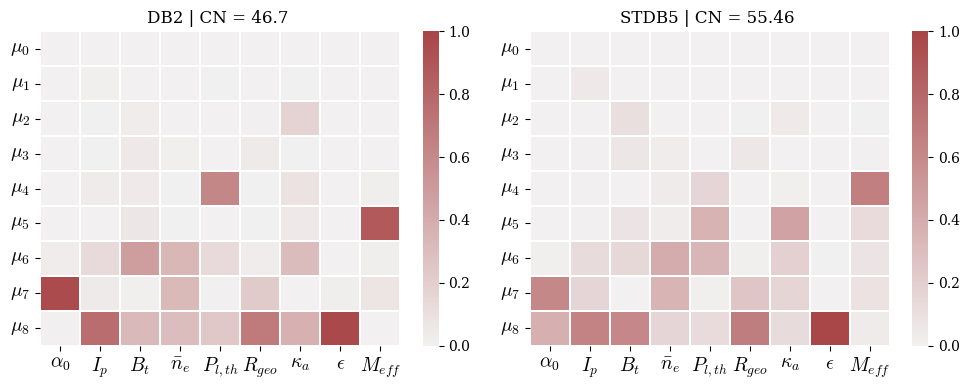

In [8]:
print(f"CI (DB2): {np.round(tokamakTK.get_condition_index(all_cases[0]),2)}")
print(f"CI (DB5): {np.round(tokamakTK.get_condition_index(all_cases[1]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting subplot 1
sns.heatmap(Π[0], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"DB2 | CN = {round(get_condition_number(all_cases[0]),2)} ")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plotting subplot 2
sns.heatmap(Π[1], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"STDB5 | CN = {round(get_condition_number(all_cases[1]),2)} ")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

size = 14
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=size)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=size)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=size)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=size)

# Adjust the layout and spacing between subplots
plt.tight_layout()
plt.savefig(fig_path+"VD_DB2_DB5.pdf", format="pdf", dpi=800, bbox_inches='tight');

Case: alpha-R 0.6357
CI (DB5 | d)label=1 + DB2: [ 1.    2.46  5.11  6.53 11.45 12.55 16.42 26.79 46.81]
CI (DB5 | u): [ 1.    2.67  5.44  7.02 11.81 13.56 17.7  29.45 57.2 ]


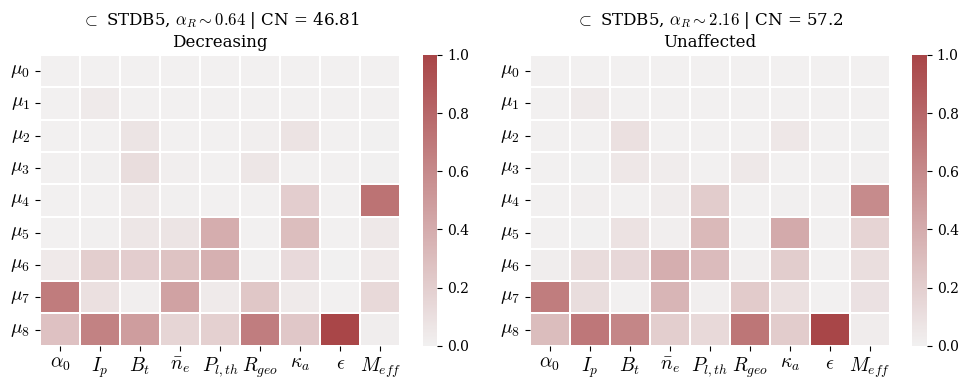

In [9]:
print("Case: alpha-R 0.6357")
print(f"CI (DB5 | d)label=1 + DB2: {np.round(tokamakTK.get_condition_index(all_cases[2]),2)}")
print(f"CI (DB5 | u): {np.round(tokamakTK.get_condition_index(all_cases[3]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting subplot 1
sns.heatmap(Π[2], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"$\\subset$ STDB5, $\\alpha_R \\sim 0.64$ | CN = {round(get_condition_number(all_cases[2]),2)}\nDecreasing")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plotting subplot 2
sns.heatmap(Π[3], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"$\\subset$ STDB5, $\\alpha_R \\sim 2.16$ | CN = {round(get_condition_number(all_cases[3]),2)}\nUnaffected")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

size = 14
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=size)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=size)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=size)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=size)

# Adjust the layout and spacing between subplots
plt.tight_layout()
plt.savefig(fig_path+"VD_STDB564.pdf", format="pdf", dpi=800, bbox_inches='tight');

Case: alpha-R 0.9998
CI (DB5 | d): [ 1.    2.36  5.32  6.16 10.86 11.68 16.47 27.23 46.05]
CI (DB5 | u): [ 1.    2.7   5.4   7.1  12.05 14.01 17.61 29.45 55.79]


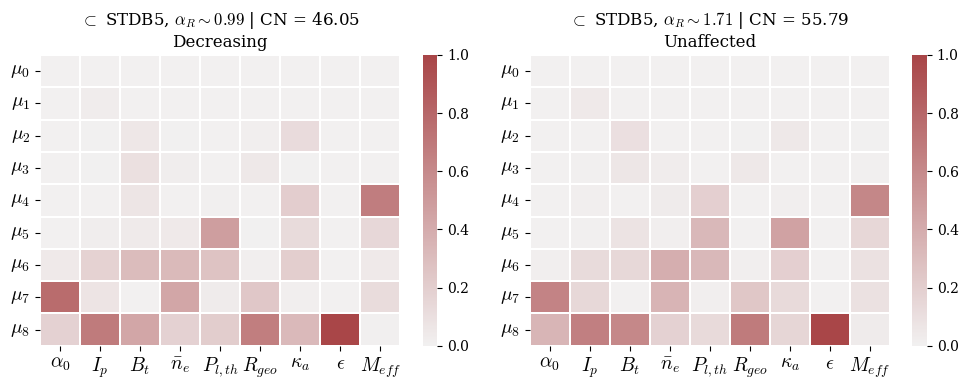

In [10]:
print("Case: alpha-R 0.9998")
print(f"CI (DB5 | d): {np.round(tokamakTK.get_condition_index(all_cases[4]),2)}")
print(f"CI (DB5 | u): {np.round(tokamakTK.get_condition_index(all_cases[5]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting subplot 1
sns.heatmap(Π[4], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"$\\subset$ STDB5, $\\alpha_R \\sim 0.99$ | CN = {round(get_condition_number(all_cases[4]),2)}\nDecreasing")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plotting subplot 2
sns.heatmap(Π[5], vmin=0, vmax=1, linecolor="white", linewidth=0.1, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"$\\subset$ STDB5, $\\alpha_R \\sim 1.71$ | CN = {round(get_condition_number(all_cases[5]),2)}\nUnaffected")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

size = 14
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=size)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=size)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=size)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=size)

# Adjust the layout and spacing between subplots
plt.tight_layout()
plt.savefig(fig_path+"VD_STDB599.pdf", format="pdf", dpi=800, bbox_inches='tight');

## Variance Inflation Factor (VIF) and Tolerance

The Variation Inflation Factor (VIF) is a measure of multicollinearity in a linear regression model. It quantifies the degree to which the variance of the estimated regression coefficient is inflated due to collinearity in the predictors.

"One recommendation is that **if VIF is greater than 5**, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this." [[statsmodels]](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

$$
    \text{VIF}_j = \frac{1}{1-R^2_j}.
$$

With $R^2_j$ being the coefficient of determination for the regression of $x_j$ on the remaining variables; namely, 

$$
    R^2 = 1 - \frac{RSS}{TSS}.
$$

With $RSS$ being the sum of squares of residuals; and, $TSS$ the total sum of squares;

$$
    SSR = \sum_i\left( \hat{y} - \bar{y} \right)^2; \quad \text{and} \quad TSS = \sum_i\left( y - \bar{y} \right)^2
$$

**Tolerance** is the inverse of VIF and relates to the proportion of variance in a predictor variable. A **tolerance value less than 0.1** is generally considered to be indicative of problematic multicollinearity.|

In [30]:
features = ['BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
features_latex = ["$B_t$","$\\bar{n}_e$","$P_{l,th}$","$R_{geo}$","$\\kappa_a$","$\\epsilon$","$M_{eff}$"]

In [31]:
all_cases = [prepare_data(DB2.copy(), features, False),  #0 DB2
             prepare_data(DB5.copy(), features, False),  #1 DB2
             prepare_data(DB5[DB5.label_6357.isin([1]) | DB5.id.isin(DB2.id.values)], features, False),  #2 Decreasing DB5 ~ 0.64
             prepare_data(DB5[DB5.label_6357.isin([0])], features, False),                               #3 Unaffected DB5 ~ 0.64
             prepare_data(DB5[DB5.label_9998.isin([1]) | DB5.id.isin(DB2.id.values)], features, False),  #4 Decreasing DB5 ~ 0.99
             prepare_data(DB5[DB5.label_9998.isin([0])], features, False)                                #5 Unaffected DB5 ~ 0.99
]

all_cases = [tokamakTK.scale_data(case, add_intercept=True) for case in all_cases]

In [32]:
VIF = pd.DataFrame()
for c,case in enumerate(all_cases):
    VIF[f"C{c}"]=[variance_inflation_factor(case.values, f) for f in range(len(features)+1)]
VIF.index = ["$\\alpha_0$"] + features_latex
VIF.columns = ["DB2", "DB5", "DB5_big_d", "DB5_big_u", "DB5_small_d", "DB5_small_u"]

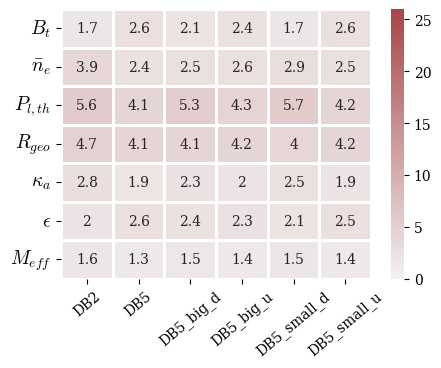

In [33]:
plt.figure(figsize=(5,3.5))
ax = sns.heatmap(VIF.loc[features_latex], vmin=0, vmax=26, annot=True,
                 cmap=sns.color_palette("light:#A84547", as_cmap=True), linecolor="white", linewidth=0.73)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=size);
#plt.savefig(fig_path+"VIF_all_datasets_noIP.pdf", format="pdf", dpi=800, bbox_inches='tight');